In [41]:
from Bio import Cluster

In [42]:
spectraMapFile = open("/usr/local/hdd/rita/spectraFile.pickle","rb")
pixel_map = pickle.load(spectraMapFile)

In [749]:
import _pickle as pickle
dot_product_all_matrix = open("/usr/local/hdd/rita/similar_methods/dot_product_all_matrix.pickle","rb")
dot_product_all = pickle.load(dot_product_all_matrix)

In [750]:
from pyimzml.ImzMLParser import ImzMLParser, browse, getionimage
parser = ImzMLParser("/usr/local/hdd/rita/msimaging/181114_AT1_Slide_D_Proteins.imzML")

In [751]:
print(len(parser.coordinates))

19026


In [752]:
print(len(pixel_map.keys())/len(parser.coordinates))

0.13339640491958374


In [753]:
import numpy as np
dist_dot_product = 1 - dot_product_all
dist_pixel = np.zeros((dist_dot_product.shape[0], dist_dot_product.shape[1]))

In [756]:
print(dot_product_all.shape)

baseCoord = np.asarray((618, 211, 1))
for iidx, i in enumerate(pixel_map.keys()):
    coordI = np.asarray(parser.coordinates[i])
    for jidx, j in enumerate(pixel_map.keys()):
        
        # - baseCoord
        coordJ = np.asarray(parser.coordinates[j])# - baseCoord

        dist = np.linalg.norm(coordI-coordJ)
        
        #print(i, j,coordI, coordJ, dist)
        dist_pixel[iidx, jidx] = dist_pixel[jidx, iidx] = dist
    
    if iidx % 100 == 0:
        print(iidx)
        
#dist_pixel = dist_pixel/np.max(dist_pixel)

(2538, 2538)
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500


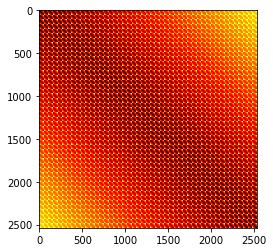

In [757]:
plt.imshow(dist_pixel, cmap='hot', interpolation='nearest')

In [758]:
normed_dist_pixel = dist_pixel / np.max(dist_pixel)
log_dist_dot = np.log(dist_dot_product+1)
log_dist_dot = log_dist_dot / np.max(log_dist_dot)

In [759]:
log_dot = np.log(dot_product_all+1)
log_dot = log_dot / np.max(log_dot)

In [760]:
general_dot_product = 0.95*log_dist_dot + 0.05*normed_dist_pixel

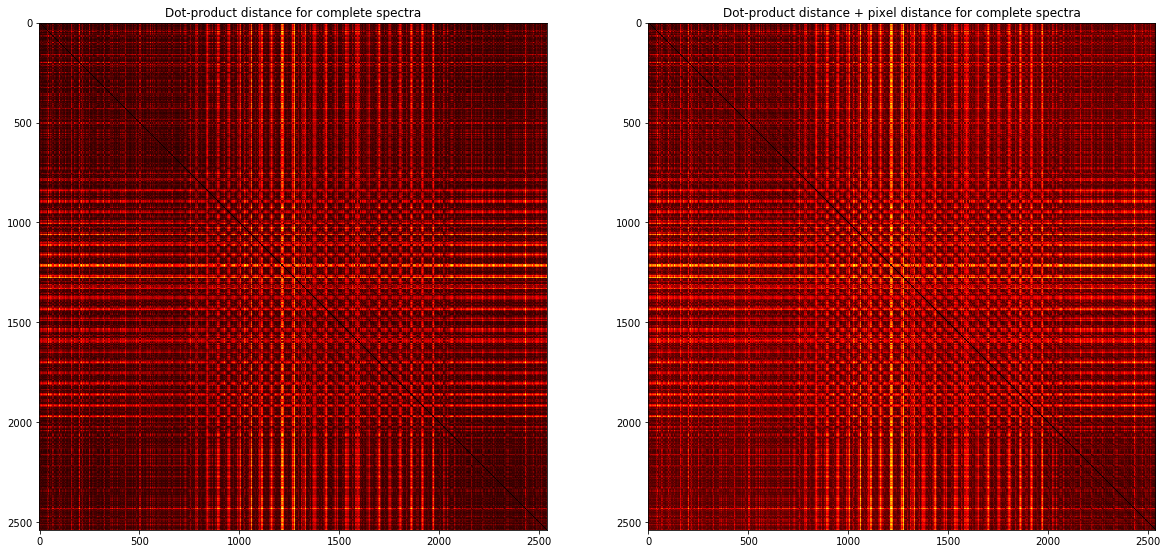

In [761]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(20, 30))
fig.add_subplot(1,2,1)
plt.imshow(dist_dot_product, cmap='hot', interpolation='nearest')
plt.title('Dot-product distance for complete spectra')
fig.add_subplot(1,2,2)
plt.imshow(general_dot_product, cmap='hot', interpolation='nearest')
plt.title('Dot-product distance + pixel distance for complete spectra')
plt.show()   

Text(0.5, 1.0, 'K medoid for dot-product and pixel distances')

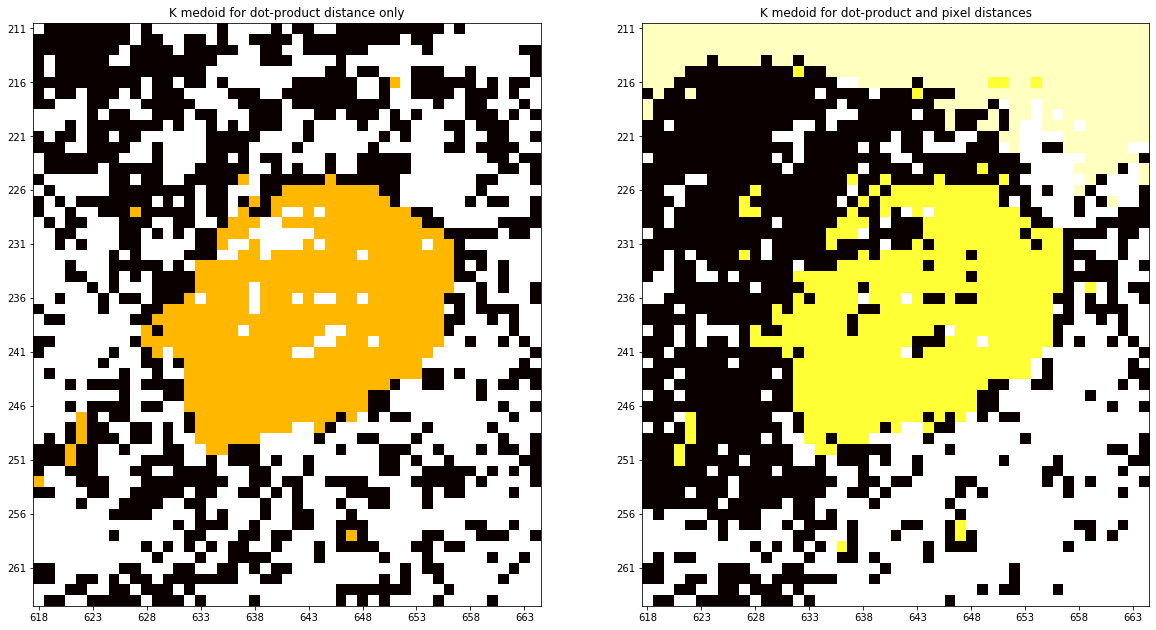

In [762]:
kmedoid_dot = Cluster.kmedoids(dist_dot_product, nclusters=3, npass=5, initialid=None) #Distance Matrix!!!
kmedoid_pixel = Cluster.kmedoids(general_dot_product, nclusters=4, npass=5, initialid=None) #Distance Matrix!!!
image_kmedoid_dot = np.zeros((265-211, 665-618))
image_kmedoid_pixel = np.zeros((265-211, 665-618))
ids = list(pixel_map.keys())
for i in ids:
    image_kmedoid_dot[parser.coordinates[i][1]-211][parser.coordinates[i][0]-618] = kmedoid_dot[0][ids.index(i)]
    image_kmedoid_pixel[parser.coordinates[i][1]-211][parser.coordinates[i][0]-618] = kmedoid_pixel[0][ids.index(i)]

fig = plt.figure(figsize=(20, 30))
fig.add_subplot(1,2,1)
plt.imshow(image_kmedoid_dot, cmap='hot', interpolation='nearest')
plt.xticks(range(0,665-618,5), np.arange(618,665,5))
plt.yticks(range(0,265-211,5), np.arange(211,265,5))
plt.title('K medoid for dot-product distance only')
fig.add_subplot(1,2,2)
plt.imshow(image_kmedoid_pixel, cmap='hot', interpolation='nearest')
plt.xticks(range(0,665-618,5), np.arange(618,665,5))
plt.yticks(range(0,265-211,5), np.arange(211,265,5))
plt.title('K medoid for dot-product and pixel distances')

Text(0.5, 1.0, '3 clusters K means all')

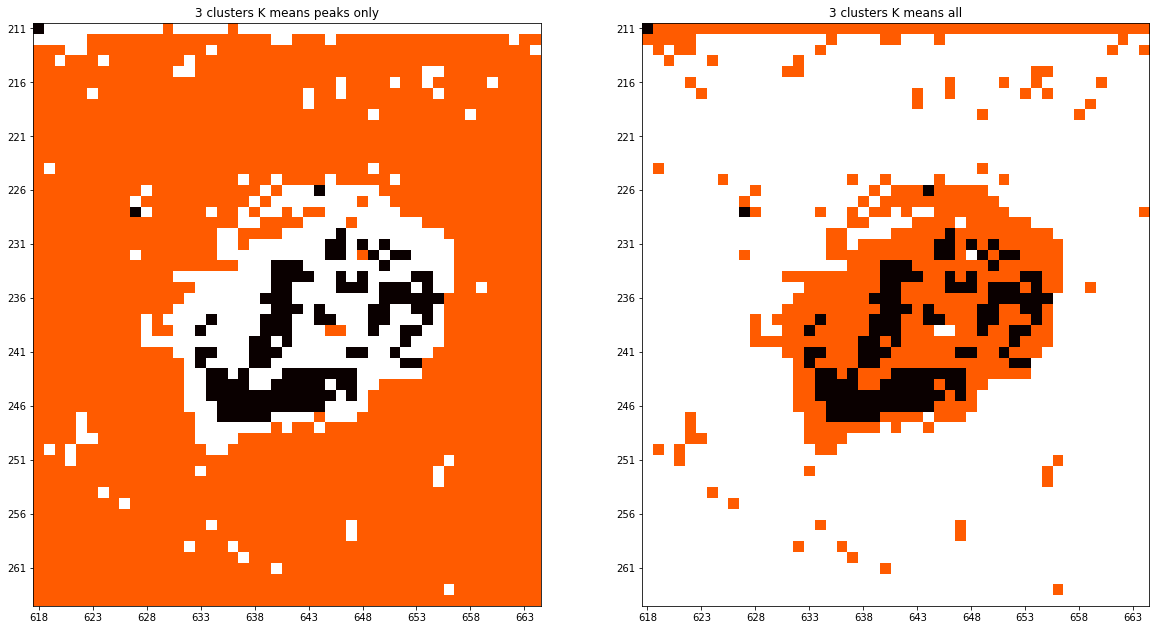

In [763]:
from sklearn.cluster import KMeans
kmeans1 = KMeans(n_clusters=3, random_state=0).fit(dist_dot_product)
kmeans2 = KMeans(n_clusters=3, random_state=0).fit(general_dot_product)
image_kmeans_dot = np.zeros((265-211, 665-618))
image_kmeans_pixel = np.zeros((265-211, 665-618))
ids = list(pixel_map.keys())
for i in ids:
    image_kmeans_dot[parser.coordinates[i][1]-211][parser.coordinates[i][0]-618] = kmeans1.labels_[ids.index(i)]
    image_kmeans_pixel[parser.coordinates[i][1]-211][parser.coordinates[i][0]-618] = kmeans2.labels_[ids.index(i)]

fig = plt.figure(figsize=(20, 30))
fig.add_subplot(1,2,1)
plt.imshow(image_kmeans_dot, cmap='hot', interpolation='nearest')
plt.xticks(range(0,665-618,5), np.arange(618,665,5))
plt.yticks(range(0,265-211,5), np.arange(211,265,5))
plt.title('3 clusters K means peaks only')
fig.add_subplot(1,2,2)
plt.imshow(image_kmeans_pixel, cmap='hot', interpolation='nearest')
plt.xticks(range(0,665-618,5), np.arange(618,665,5))
plt.yticks(range(0,265-211,5), np.arange(211,265,5))
plt.title('3 clusters K means all')

The k-means algorithm can have difficulties when the clusters are not convex shapes.

Text(0.5, 1.0, 'SpectralClustering(3) for dot-product and pixel distances')

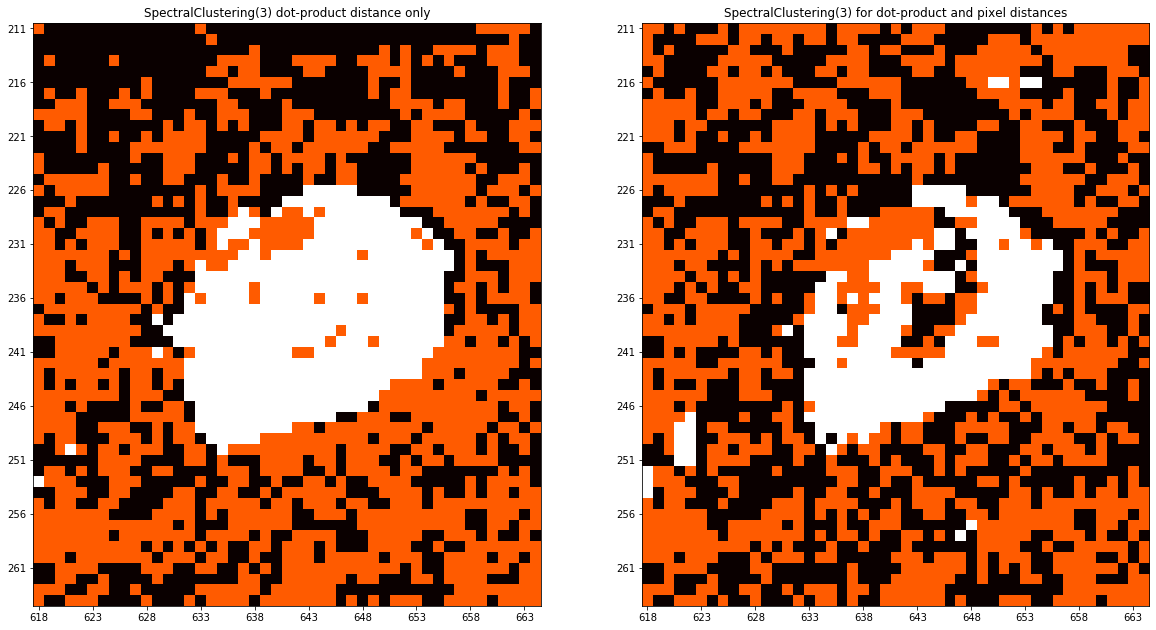

In [764]:
from sklearn.cluster import SpectralClustering
sp1 = SpectralClustering(3, affinity='precomputed', n_init=10).fit_predict(dot_product_all)
sp2 = SpectralClustering(3, affinity='precomputed', n_init=10).fit_predict(dot_product_all + 0.01*dist_pixel)
image_sp_dot = np.zeros((265-211, 665-618))
image_sp_pixel = np.zeros((265-211, 665-618))
ids = list(pixel_map.keys())
for i in ids:
    image_sp_dot[parser.coordinates[i][1]-211][parser.coordinates[i][0]-618] = sp1[ids.index(i)]
    image_sp_pixel[parser.coordinates[i][1]-211][parser.coordinates[i][0]-618] = sp2[ids.index(i)]

fig = plt.figure(figsize=(20, 30))
fig.add_subplot(1,2,1)
plt.imshow(image_sp_dot, cmap='hot', interpolation='nearest')
plt.xticks(range(0,665-618,5), np.arange(618,665,5))
plt.yticks(range(0,265-211,5), np.arange(211,265,5))
plt.title('SpectralClustering(3) dot-product distance only')
fig.add_subplot(1,2,2)
plt.imshow(image_sp_pixel, cmap='hot', interpolation='nearest')
plt.xticks(range(0,665-618,5), np.arange(618,665,5))
plt.yticks(range(0,265-211,5), np.arange(211,265,5))
plt.title('SpectralClustering(3) for dot-product and pixel distances')

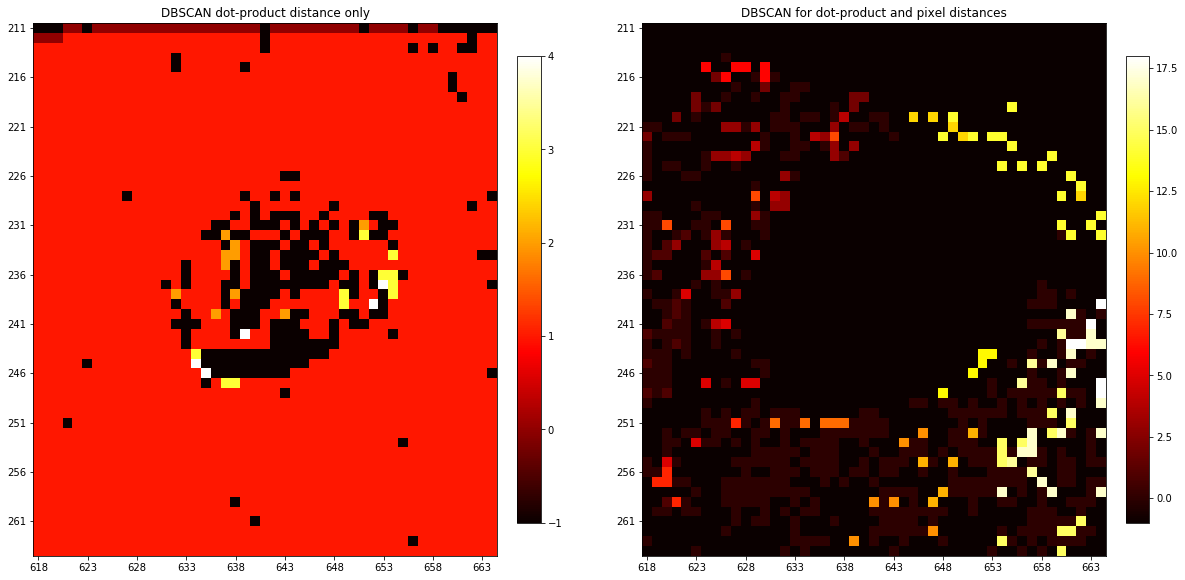

In [765]:
from sklearn.cluster import DBSCAN
dbscan1 = DBSCAN().fit(dist_dot_product)
dbscan2 = DBSCAN().fit(general_dot_product)
image_dbscan_dot = np.zeros((265-211, 665-618))
image_dbscan_pixel= np.zeros((265-211, 665-618))
ids = list(pixel_map.keys())
for i in ids:
    image_dbscan_dot[parser.coordinates[i][1]-211][parser.coordinates[i][0]-618] = dbscan1.labels_[ids.index(i)]
    image_dbscan_pixel[parser.coordinates[i][1]-211][parser.coordinates[i][0]-618] = dbscan2.labels_[ids.index(i)]

fig = plt.figure(figsize=(20, 30))
fig.add_subplot(1,2,1)
im = plt.imshow(image_dbscan_dot, cmap='hot', interpolation='nearest')
plt.xticks(range(0,665-618,5), np.arange(618,665,5))
plt.yticks(range(0,265-211,5), np.arange(211,265,5))
plt.title('DBSCAN dot-product distance only')
plt.colorbar(im, fraction=0.046, pad=0.04)
fig.add_subplot(1,2,2)
im = plt.imshow(image_dbscan_pixel, cmap='hot', interpolation='nearest')
plt.xticks(range(0,665-618,5), np.arange(618,665,5))
plt.yticks(range(0,265-211,5), np.arange(211,265,5))
plt.title('DBSCAN for dot-product and pixel distances')
plt.colorbar(im, fraction=0.046, pad=0.04)

UPGMA

In [766]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform
np.fill_diagonal(log_dist_dot, 0)
np.fill_diagonal(general_dot_product, 0)
Z1 = linkage(squareform(log_dist_dot), method = 'average', metric = 'cosine')
Z2 = linkage(squareform(general_dot_product), method = 'average', metric = 'cosine')

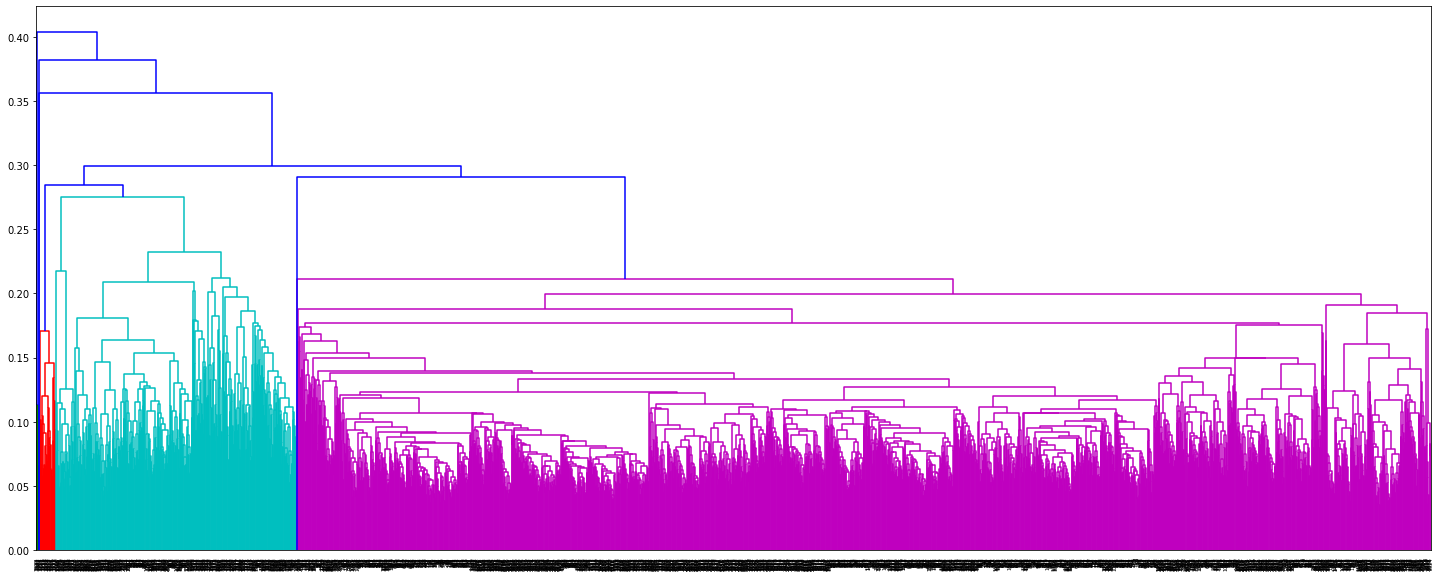

In [767]:
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z2)
plt.show()

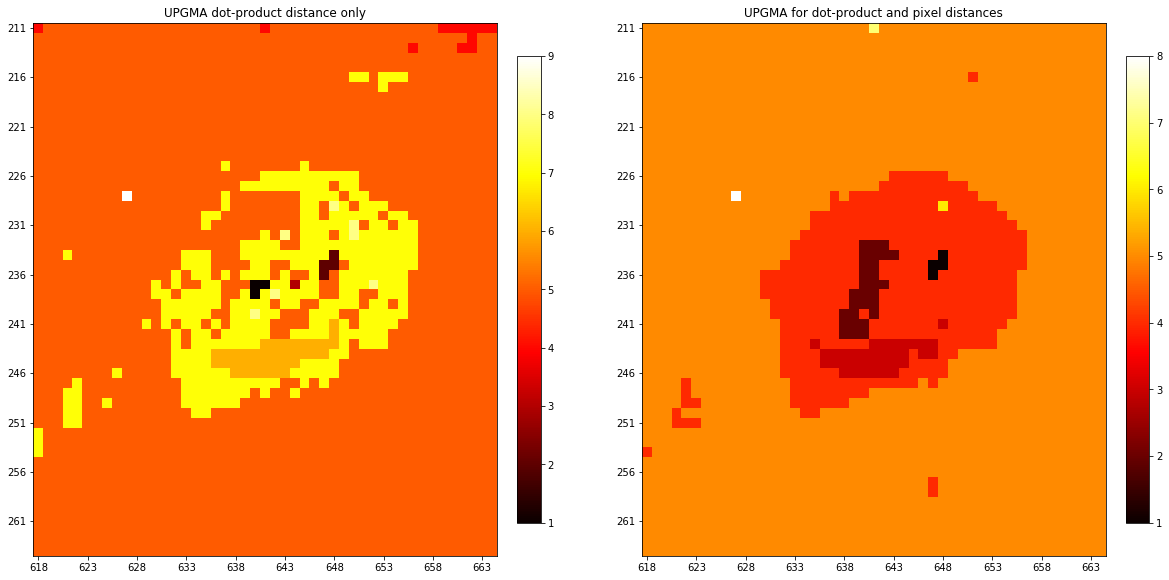

In [768]:
c1 = fcluster(Z1, t=0.25, criterion='distance')
c2 = fcluster(Z2, t=0.25, criterion='distance')
image_UPGMA_dot = np.zeros((265-211, 665-618))
image_UPGMA_pixel= np.zeros((265-211, 665-618))
ids = list(pixel_map.keys())
for i in ids:
    image_UPGMA_dot[parser.coordinates[i][1]-211][parser.coordinates[i][0]-618] = c1[ids.index(i)]
    image_UPGMA_pixel[parser.coordinates[i][1]-211][parser.coordinates[i][0]-618] = c2[ids.index(i)]

fig = plt.figure(figsize=(20, 30))
fig.add_subplot(1,2,1)
im = plt.imshow(image_UPGMA_dot, cmap='hot', interpolation='nearest')
plt.xticks(range(0,665-618,5), np.arange(618,665,5))
plt.yticks(range(0,265-211,5), np.arange(211,265,5))
plt.title('UPGMA dot-product distance only')
plt.colorbar(im, fraction=0.046, pad=0.04)
fig.add_subplot(1,2,2)
im = plt.imshow(image_UPGMA_pixel, cmap='hot', interpolation='nearest')
plt.xticks(range(0,665-618,5), np.arange(618,665,5))
plt.yticks(range(0,265-211,5), np.arange(211,265,5))
plt.title('UPGMA for dot-product and pixel distances')
plt.colorbar(im, fraction=0.046, pad=0.04)

UPGMC

In [770]:
np.fill_diagonal(dist_dot_product, 0)
np.fill_diagonal(general_dot_product, 0)
Z1 = linkage(squareform(dist_dot_product), method = 'centroid', metric = 'cosine')
Z2 = linkage(squareform(general_dot_product), method = 'centroid', metric = 'cosine')

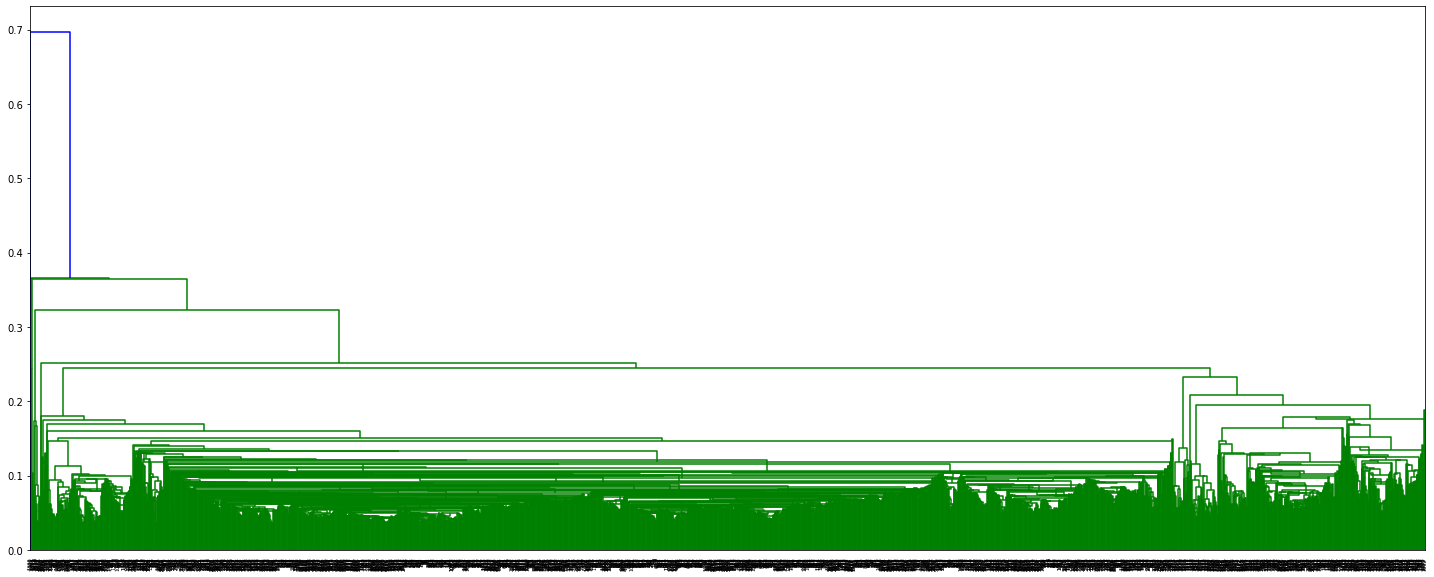

In [771]:
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z2)
plt.show()

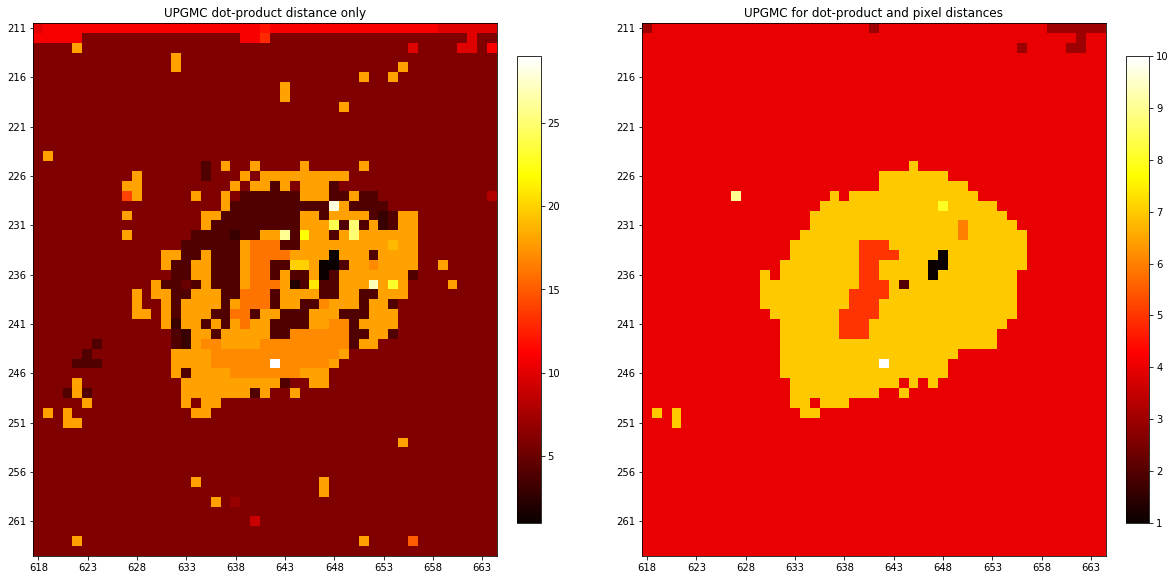

In [772]:
c1 = fcluster(Z1, t=0.07, criterion='distance')
c2 = fcluster(Z2, t=0.2, criterion='distance')
image_UPGMA_dot = np.zeros((265-211, 665-618))
image_UPGMA_pixel= np.zeros((265-211, 665-618))
ids = list(pixel_map.keys())
for i in ids:
    image_UPGMA_dot[parser.coordinates[i][1]-211][parser.coordinates[i][0]-618] = c1[ids.index(i)]
    image_UPGMA_pixel[parser.coordinates[i][1]-211][parser.coordinates[i][0]-618] = c2[ids.index(i)]

fig = plt.figure(figsize=(20, 30))
fig.add_subplot(1,2,1)
im = plt.imshow(image_UPGMA_dot, cmap='hot', interpolation='nearest')
plt.xticks(range(0,665-618,5), np.arange(618,665,5))
plt.yticks(range(0,265-211,5), np.arange(211,265,5))
plt.title('UPGMC dot-product distance only')
plt.colorbar(im, fraction=0.046, pad=0.04)
fig.add_subplot(1,2,2)
im = plt.imshow(image_UPGMA_pixel, cmap='hot', interpolation='nearest')
plt.xticks(range(0,665-618,5), np.arange(618,665,5))
plt.yticks(range(0,265-211,5), np.arange(211,265,5))
plt.title('UPGMC for dot-product and pixel distances')
plt.colorbar(im, fraction=0.046, pad=0.04)

Ward’s linkage

In [773]:
Z1 = linkage(squareform(dist_dot_product), method = 'ward', metric = 'cosine')
Z2 = linkage(squareform(general_dot_product), method = 'ward', metric = 'cosine')

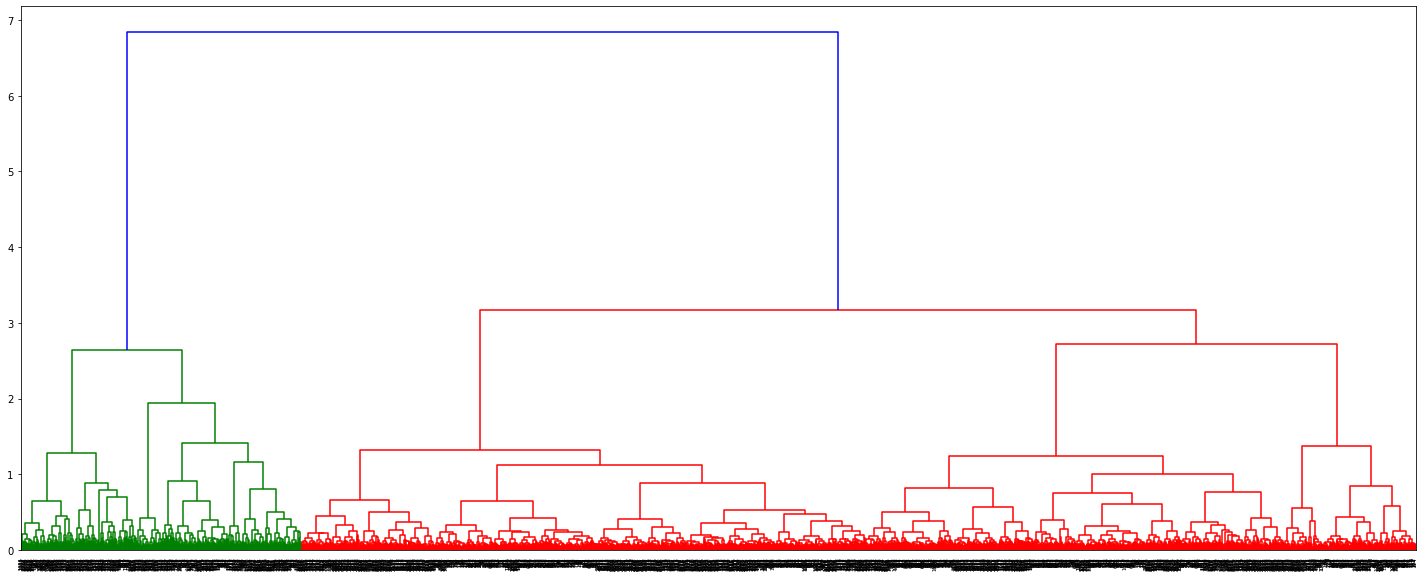

In [774]:
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z2)
plt.show()

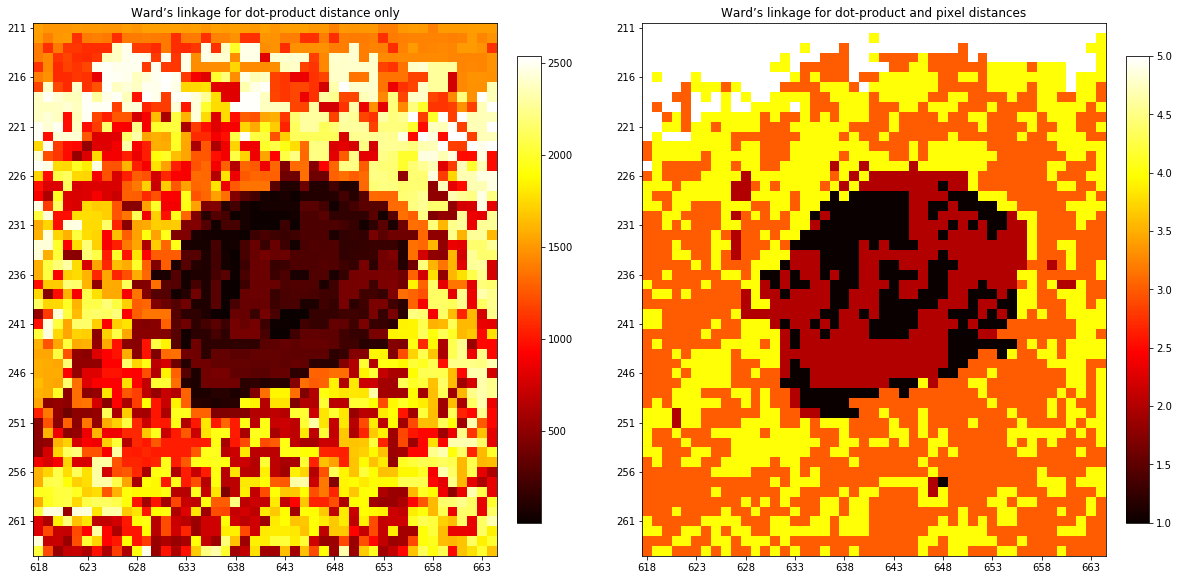

In [775]:
c1 = fcluster(Z1, t=0, criterion='distance')
c2 = fcluster(Z2, t=2, criterion='distance')
image_UPGMA_dot = np.zeros((265-211, 665-618))
image_UPGMA_pixel= np.zeros((265-211, 665-618))
ids = list(pixel_map.keys())
for i in ids:
    image_UPGMA_dot[parser.coordinates[i][1]-211][parser.coordinates[i][0]-618] = c1[ids.index(i)]
    image_UPGMA_pixel[parser.coordinates[i][1]-211][parser.coordinates[i][0]-618] = c2[ids.index(i)]

fig = plt.figure(figsize=(20, 30))
fig.add_subplot(1,2,1)
im = plt.imshow(image_UPGMA_dot, cmap='hot', interpolation='nearest')
plt.xticks(range(0,665-618,5), np.arange(618,665,5))
plt.yticks(range(0,265-211,5), np.arange(211,265,5))
plt.title('Ward’s linkage for dot-product distance only')
plt.colorbar(im, fraction=0.046, pad=0.04)
fig.add_subplot(1,2,2)
im = plt.imshow(image_UPGMA_pixel, cmap='hot', interpolation='nearest')
plt.xticks(range(0,665-618,5), np.arange(618,665,5))
plt.yticks(range(0,265-211,5), np.arange(211,265,5))
plt.title('Ward’s linkage for dot-product and pixel distances')
plt.colorbar(im, fraction=0.046, pad=0.04)

Birch clustering algorithm

In [776]:
from sklearn.cluster import Birch

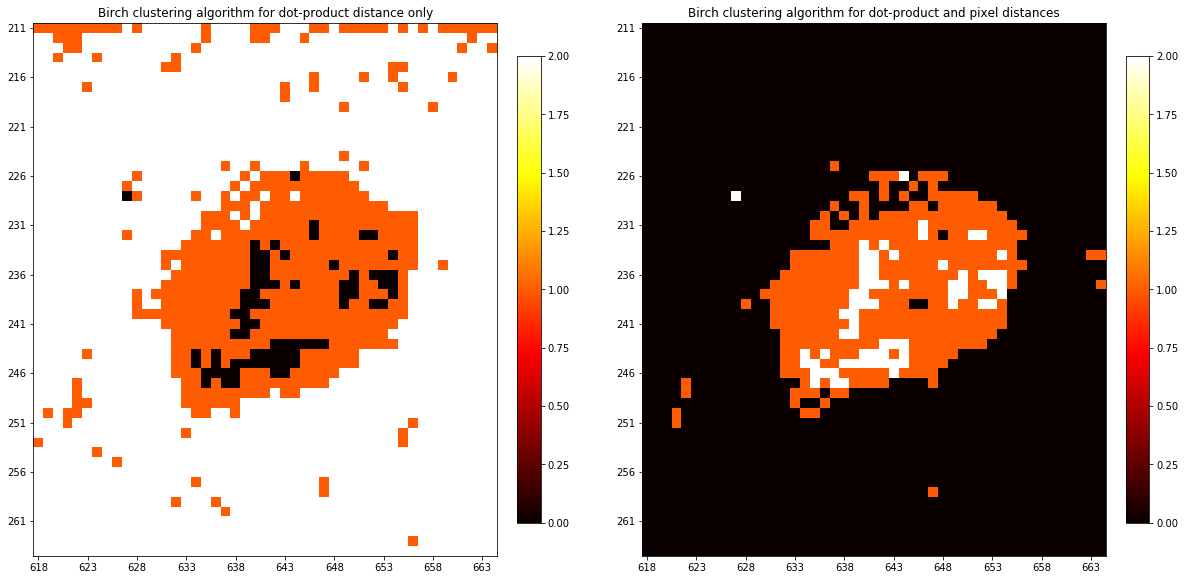

In [777]:
brc1 = Birch(branching_factor=50, n_clusters=3, threshold=0.5, compute_labels=True)
brc1.fit(dist_dot_product) 
brc1.predict(dist_dot_product)

brc2 = Birch(branching_factor=50, n_clusters=3, threshold=0.5, compute_labels=True)
brc2.fit(general_dot_product) 
brc2.predict(general_dot_product)

image_birch_dot = np.zeros((265-211, 665-618))
image_birch_pixel= np.zeros((265-211, 665-618))
ids = list(pixel_map.keys())
for i in ids:
    image_birch_dot[parser.coordinates[i][1]-211][parser.coordinates[i][0]-618] = brc1.labels_[ids.index(i)]
    image_birch_pixel[parser.coordinates[i][1]-211][parser.coordinates[i][0]-618] = brc2.labels_[ids.index(i)]

fig = plt.figure(figsize=(20, 30))
fig.add_subplot(1,2,1)
im = plt.imshow(image_birch_dot, cmap='hot', interpolation='nearest')
plt.xticks(range(0,665-618,5), np.arange(618,665,5))
plt.yticks(range(0,265-211,5), np.arange(211,265,5))
plt.title('Birch clustering algorithm for dot-product distance only')
plt.colorbar(im, fraction=0.046, pad=0.04)
fig.add_subplot(1,2,2)
im = plt.imshow(image_birch_pixel, cmap='hot', interpolation='nearest')
plt.xticks(range(0,665-618,5), np.arange(618,665,5))
plt.yticks(range(0,265-211,5), np.arange(211,265,5))
plt.title('Birch clustering algorithm for dot-product and pixel distances')
plt.colorbar(im, fraction=0.046, pad=0.04)

Agglomerate features

In [778]:
from sklearn.cluster import FeatureAgglomeration

In [779]:
fag1 = FeatureAgglomeration(n_clusters=3, affinity='cosine', linkage='complete')
fag1.fit(dot_product_all)
fag1.labels_

array([2, 2, 1, ..., 2, 2, 1])

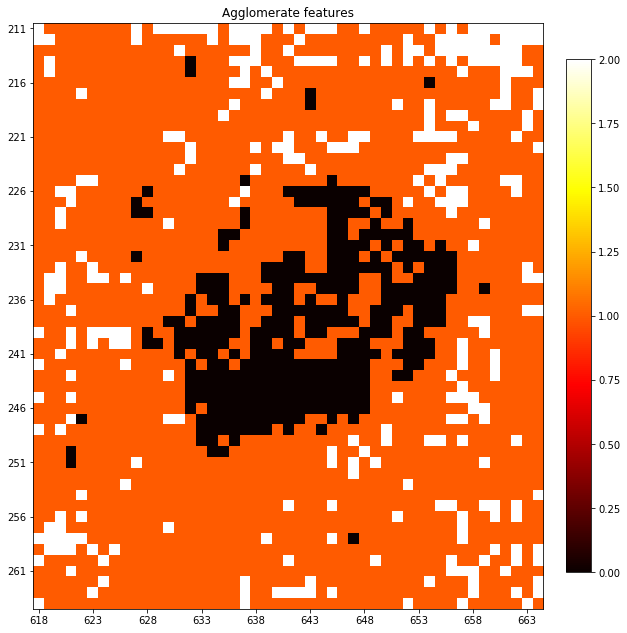

In [780]:
image = np.zeros((265-211, 665-618))
ids = list(pixel_map.keys())
for i in ids:
    image[parser.coordinates[i][1]-211][parser.coordinates[i][0]-618] = fag1.labels_[ids.index(i)]

fig = plt.figure(figsize=(10, 15))
im = plt.imshow(image, cmap='hot', interpolation='nearest')
plt.xticks(range(0,665-618,5), np.arange(618,665,5))
plt.yticks(range(0,265-211,5), np.arange(211,265,5))
plt.title('Agglomerate features')
plt.colorbar(im, fraction=0.046, pad=0.04)

In [781]:
from skbio import DistanceMatrix
from skbio.tree import nj

In [782]:
ids = list(pixel_map.keys())
ids = list(map(str, ids))
dm = DistanceMatrix(general_dot_product, ids)

In [783]:
tree = nj(dm)

In [784]:
cluster = 1
NJ = np.zeros((265-211, 665-618))
for s in tree.subsets():
    a = np.array(list(s))
    if len(a)<800:
        for i in a:
            NJ[parser.coordinates[int(i)][1]-211][parser.coordinates[int(i)][0]-618] = 0
    else:
        for i in a:
            NJ[parser.coordinates[int(i)][1]-211][parser.coordinates[int(i)][0]-618] = cluster
        cluster += 1

In [785]:
cluster

21

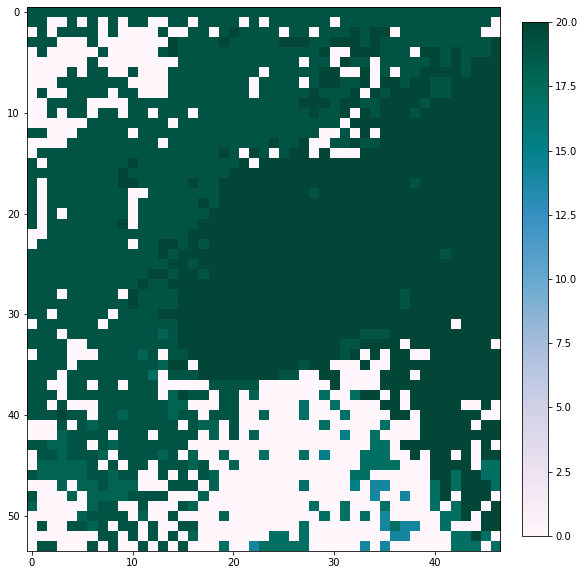

In [786]:
plt.figure(figsize=(10, 10))
im = plt.imshow(NJ, cmap='PuBuGn', interpolation='nearest')
plt.colorbar(im, fraction=0.046, pad=0.04)

In [787]:
print(tree.ascii_art())

                                        /-12906
                              /--------|
                             |         |          /-12908
                             |          \--------|
                    /--------|                    \-12907
                   |         |
                   |         |          /-13053
                   |          \--------|
                   |                   |          /-12952
                   |                    \--------|
                   |                             |          /-12854
                   |                              \--------|
                   |                                       |          /-12903
                   |                                        \--------|
                   |                                                  \-12853
                   |
                   |                    /-12953
                   |          /--------|
                   |         |         |         

In [788]:
mat = tree.tip_tip_distances()

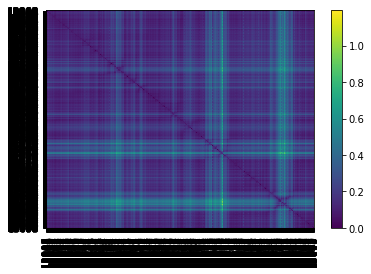

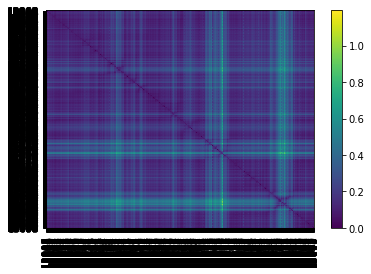

In [789]:
mat.plot()

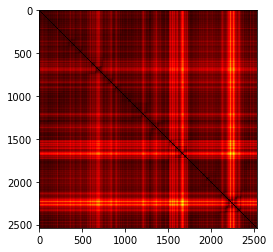

In [790]:
plt.imshow(mat.data, cmap='hot', interpolation='nearest')

In [498]:
res = tree.to_array()
res.keys()

dict_keys(['id_index', 'child_index', 'name', 'length', 'id'])

In [499]:
res['child_index']

array([[   3,    0,    1],
       [   7,    4,    5],
       [   9,    6,    7],
       ...,
       [5071, 4900, 4901],
       [5072, 5068, 5069],
       [5073, 5070, 5072]])

In [500]:
for k, v in res['id_index'].items():
    print(k, v)

0 1990:0.016526;

1 1936:0.023478;

2 1882:0.018906;

3 (1990:0.016526,1936:0.023478):0.001607;

4 1720:0.024197;

5 1665:0.025309;

6 1719:0.021707;

7 (1720:0.024197,1665:0.025309):0.004697;

8 1721:0.02436;

9 (1719:0.021707,(1720:0.024197,1665:0.025309):0.004697):0.002735;

10 1885:0.029355;

11 (1721:0.02436,(1719:0.021707,(1720:0.024197,1665:0.025309):0.004697):0.002735):0.002332;

12 (1882:0.018906,(1990:0.016526,1936:0.023478):0.001607):0.002018;

13 (1885:0.029355,(1721:0.02436,(1719:0.021707,(1720:0.024197,1665:0.025309):0.004697):0.002735):0.002332):0.00022;

14 1825:0.021336;

15 1773:0.026931;

16 1770:0.018526;

17 (1825:0.021336,1773:0.026931):0.001053;

18 1557:0.031058;

19 (1770:0.018526,(1825:0.021336,1773:0.026931):0.001053):0.000724;

20 1664:0.028169;

21 (1557:0.031058,(1770:0.018526,(1825:0.021336,1773:0.026931):0.001053):0.000724):0.002127;

22 1716:0.027982;

23 (1664:0.028169,(1557:0.031058,(1770:0.018526,(1825:0.021336,1773:0.026931):0.001053):0.000724):0.00

915 (931:0.037284,877:0.033316):0.003074;

916 607:0.033133;

917 549:0.042685;

918 (982:0.045735,(931:0.037284,877:0.033316):0.003074):0.003875;

919 (607:0.033133,549:0.042685):0.003696;

920 (390:0.042215,389:0.06062):0.005619;

921 ((982:0.045735,(931:0.037284,877:0.033316):0.003074):0.003875,(607:0.033133,549:0.042685):0.003696):0.002538;

922 443:0.035409;

923 ((390:0.042215,389:0.06062):0.005619,((982:0.045735,(931:0.037284,877:0.033316):0.003074):0.003875,(607:0.033133,549:0.042685):0.003696):0.002538):0.004082;

924 ((331:0.042637,330:0.05474):0.007348,(923:0.030256,(981:0.030412,(1087:0.03942,(978:0.053554,((1032:0.025671,(1033:0.043203,815:0.038604):0.003204):0.006136,(1143:0.045491,(1197:0.029473,(1410:0.038071,(1307:0.033955,(1411:0.025917,1359:0.04071):0.002242):0.003607):0.004086):0.002705):0.004634):0.003799):0.00284):0.004301):0.001244):0.00496):0.002577;

925 (443:0.035409,((390:0.042215,389:0.06062):0.005619,((982:0.045735,(931:0.037284,877:0.033316):0.003074):0.00


1905 (((987:0.038969,(((1524:0.035275,(1631:0.029417,(1415:0.01984,(1414:0.029133,((1469:0.02595,1468:0.019052):0.006091,(1523:0.023131,(1577:0.023942,(1630:0.038092,1576:0.028049):0.004779):0.001024):0.004281):0.001209):0.006275):0.003053):0.006603):0.002795,(1417:0.028185,1416:0.029855):0.001888):0.001716,(1579:0.031018,1525:0.037706):0.00103):0.006745):0.004832,((777:0.031281,(((1364:0.030384,(1634:0.03586,1526:0.043206):0.005116):0.00353,((936:0.025439,883:0.017649):0.008685,((((792:0.048429,733:0.04415):0.00393,(1065:0.036442,(1225:0.056327,(((624:0.044253,(956:0.04461,(1064:0.028455,(1118:0.029743,(902:0.028645,(846:0.053518,(1171:0.037232,(1386:0.038346,(1009:0.02633,(((1868:0.029202,1814:0.027731):0.006384,(1707:0.031524,1493:0.037463):0.002431):0.011399,(1063:0.035351,(944:0.032822,((941:0.042819,889:0.045495):0.006665,(844:0.056097,(900:0.025998,(1117:0.024706,(955:0.031416,(901:0.044745,899:0.047706):0.005718):0.010487):0.004052):0.011354):0.005203):0.005439):0.010788):0.00

2586 ((((913:0.034761,((1125:0.033971,1019:0.036336):0.003518,(1018:0.032785,966:0.034636):0.001318):0.000287):0.004214,(((746:0.032525,(909:0.03277,(959:0.036611,908:0.032001):0.00262):0.001824):0.001964,(1067:0.025645,(1017:0.022047,(962:0.020519,802:0.027824):0.001482):0.001166):0.000483):0.00143,((628:0.041429,(795:0.031415,((1226:0.047638,(794:0.048816,(737:0.048241,734:0.038109):0.004788):0.001571):0.004662,(849:0.029477,796:0.041321):0.000972):0.001468):0.001686):0.002774,(1013:0.029355,((1282:0.026391,(1443:0.033153,(1283:0.025252,1174:0.023902):0.002035):0.00133):0.004239,(1230:0.02121,(1070:0.023502,1014:0.020002):0.002061):0.000794):0.001685):0.001661):0.001257):0.000397):0.000833,(((644:0.02853,(695:0.021267,(697:0.019683,((694:0.022772,641:0.022876):0.002216,(749:0.025452,(693:0.030231,(751:0.033149,593:0.035544):0.005523):0.001405):0.000944):0.001027):0.000839):0.001642):0.003125,(((376:0.030527,(266:0.032436,(((160:0.036795,((215:0.028926,213:0.029994):0.00221,((269:0.05


3314 1273:0.041438;

3315 (1157:0.030041,(1159:0.059786,((1264:0.046272,(1269:0.027263,(1319:0.024402,(1373:0.038065,(1212:0.027297,((1322:0.019751,(1266:0.009574,(1213:0.035814,(1267:0.035545,1215:0.061575):0.008335):0.03061):0.011312):0.012611,(1161:0.056904,(1270:0.029841,(1164:0.021341,(1165:0.030118,(1265:0.068129,(1109:0.033255,(1210:0.008726,(1211:0.035483,(1162:0.020677,(1318:0.024656,((1268:0.061347,1214:0.005119):0.047844,(1216:0.0,1163:0.057662):0.020357):0.015945):0.01962):0.021735):0.022545):0.012436):0.011168):0.006466):0.010424):0.007832):0.006274):0.005506):0.01069):0.011259):0.011761):0.021924):0.011372):0.014676,(1271:0.036371,(1218:0.047789,(1111:0.06714,1110:0.006132):0.026707):0.023726):0.012405):0.008834):0.012317):0.011956;

3316 1377:0.020403;

3317 (1273:0.041438,(1157:0.030041,(1159:0.059786,((1264:0.046272,(1269:0.027263,(1319:0.024402,(1373:0.038065,(1212:0.027297,((1322:0.019751,(1266:0.009574,(1213:0.035814,(1267:0.035545,1215:0.061575):0.008335):0.03061)


4328 1329:0.0;

4329 (1222:0.0,(1330:0.111399,1276:0.0):0.032547):0.036916;

4330 1275:0.0;

4331 (1329:0.0,(1222:0.0,(1330:0.111399,1276:0.0):0.032547):0.036916):0.038601;

4332 1168:0.017974;

4333 (1275:0.0,(1329:0.0,(1222:0.0,(1330:0.111399,1276:0.0):0.032547):0.036916):0.038601):0.021533;

4334 1114:0.017453;

4335 (1168:0.017974,(1275:0.0,(1329:0.0,(1222:0.0,(1330:0.111399,1276:0.0):0.032547):0.036916):0.038601):0.021533):0.016818;

4336 1221:0.020229;

4337 (1114:0.017453,(1168:0.017974,(1275:0.0,(1329:0.0,(1222:0.0,(1330:0.111399,1276:0.0):0.032547):0.036916):0.038601):0.021533):0.016818):0.011753;

4338 1437:0.023674;

4339 1384:0.026279;

4340 1438:0.032226;

4341 (1437:0.023674,1384:0.026279):0.009745;

4342 (1221:0.020229,(1114:0.017453,(1168:0.017974,(1275:0.0,(1329:0.0,(1222:0.0,(1330:0.111399,1276:0.0):0.032547):0.036916):0.038601):0.021533):0.016818):0.011753):0.017475;

4343 (1438:0.032226,(1437:0.023674,1384:0.026279):0.009745):0.008959;

4344 1382:0.028852;

4345 ((

5070 (((1882:0.018906,(1990:0.016526,1936:0.023478):0.001607):0.002018,(1885:0.029355,(1721:0.02436,(1719:0.021707,(1720:0.024197,1665:0.025309):0.004697):0.002735):0.002332):0.00022):0.002149,((1775:0.024626,(1610:0.023287,(1716:0.027982,(1664:0.028169,(1557:0.031058,(1770:0.018526,(1825:0.021336,1773:0.026931):0.001053):0.000724):0.002127):0.000938):0.000669):0.001995):0.000996,(((1774:0.038961,(1826:0.031599,((1828:0.025356,((1827:0.049784,((1714:0.033028,(1766:0.027431,(1659:0.024443,(684:0.029769,(1497:0.026238,(1502:0.048308,(1607:0.026598,(1604:0.033209,1498:0.033811):0.01212):0.003783):0.007005):0.004218):0.003441):0.002795):0.003137):0.002291,(1286:0.039365,((1079:0.033958,(1510:0.023866,(1402:0.041215,1348:0.020734):0.004821):0.004837):0.004605,(1878:0.038509,((2042:0.02117,(2151:0.02592,(2532:0.031352,(2102:0.02538,(1889:0.025728,(2527:0.024921,(2536:0.044957,(2212:0.038683,2153:0.009082):0.011737):0.007071):0.008177):0.002543):0.006615):0.004746):0.001307):0.003195,(2088:0.

In [520]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=500, metric='precomputed', n_jobs=10)
neigh.fit(general_dot_product) 

NearestNeighbors(algorithm='auto', leaf_size=30, metric='precomputed',
                 metric_params=None, n_jobs=10, n_neighbors=500, p=2,
                 radius=1.0)

In [521]:
A = neigh.kneighbors_graph(general_dot_product)
A.toarray()

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 0., 1.]])

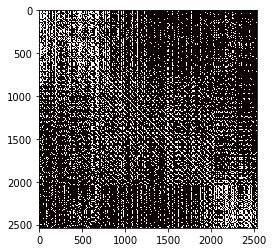

In [522]:
plt.imshow(A.toarray(), cmap='hot', interpolation='nearest')